In [1]:
import pandas as pd
import numpy as np
import re


In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_CODEGEN_50_7_0_1__8_9_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
1,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__8_9_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
2,LGBMClassifier,"'DS_CODEGEN_50_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
3,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__2_3_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
4,LGBMClassifier,"'DS_CODEGEN_50_82_0_1__8_9_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_CODEGEN_50_7_0_1__8_9_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
1,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__8_9_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
2,LGBMClassifier,"'DS_CODEGEN_50_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
3,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__2_3_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
4,LGBMClassifier,"'DS_CODEGEN_50_82_0_1__8_9_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , 300, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'monetdb'," "'mssql'," "'mysql'," "'oracle'," "'pgsql',"
 "'sqltm'," "'teradata',"]
df.shape (16044, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', DecisionTreeClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', GradientBoostingClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', OneVsRestClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'db2', XGBClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'monetdb', NuSVC_pipe 18 12
MODEL_DATASETS_MISSING 'monetdb', SVC_pipe 18 18
MODEL_DATASETS_MISSING 'mssql', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'mssql', RidgeClassifierCV_pipe 18 18
MODEL_DATASETS_MISSING 'mssql', SGDClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'mysql', ExtraTreeClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'mysql', GradientBoostingRegressor_pipe 6 6
MODEL_DATASETS_MISSING 'mysql', LGBMClassifier_

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,DecisionTreeClassifier_pipe,"'p_DS_CODEGEN_200_22_0_1__0_1_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.tree
1,DecisionTreeClassifier_pipe,"'p_DS_CODEGEN_200_22_0_1__2_3_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.tree
2,DecisionTreeClassifier_pipe,"'p_DS_CODEGEN_200_22_0_1__8_9_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.tree
3,DecisionTreeClassifier_pipe,"'p_DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.tree
4,DecisionTreeClassifier_pipe,"'p_DS_CODEGEN_200_7_0_1__2_3_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.tree


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(16384, 8)

In [19]:
df.est_dialect.value_counts()

'mysql',       2048
'mssql',       2048
'teradata',    2048
'sqltm',       2048
'oracle',      2048
'db2',         2048
'pgsql',       2048
'monetdb',     2048
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

,,error_message
est_dialect,error_message,
"'db2',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'teradata',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'sqltm',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'pgsql',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'oracle',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'mysql',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'mssql',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'monetdb',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'mysql',",TIMEOUT,80


In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,14692
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",720
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",498
TIMEOUT,340
'DatabaseError:(teradata.api.DatabaseError),66
) too many columns in result se,6
"""DatabaseError:(teradata.api.DatabaseError)",6
: SQLNumResultCols failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL0840N Too many items were returned in a SELECT list. SQLSTATE=54004 SQLCODE=-84,6
) value out of range: underflo,6
) Math exception: Numerical result out of rang,6


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

DummyClassifier                144
DummyClassifier_pipe           126
IsolationForest_pipe            45
IsolationForest                 45
NuSVC_pipe                      36
OneVsRestClassifier             24
FastICA                         24
FactorAnalysis                  18
ExtraTreesClassifier_pipe        7
Lars                             7
ExtraTreesClassifier             7
OneVsRestClassifier_pipe         3
RandomForestClassifier_pipe      3
AdaBoostClassifier               3
AdaBoostClassifier_pipe          3
EllipticEnvelope                 2
XGBClassifier                    1
Name: Model, dtype: int64

In [28]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()

LatentDirichletAllocation    144
MiniBatchSparsePCA           144
NMF                          144
KernelPCA                    144
SparsePCA                    144
Name: Model, dtype: int64

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_CODEGEN_50_7_0_1__8_9_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
1,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__8_9_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
2,LGBMClassifier,"'DS_CODEGEN_50_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
3,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__2_3_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
4,LGBMClassifier,"'DS_CODEGEN_50_82_0_1__8_9_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_CODEGEN_50_7_0_1__8_9_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_CODEGEN_200_7_0_1__8_9_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_CODEGEN_50_22_0_1__2_3_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_CODEGEN_200_82_0_1__2_3_64F62F02,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_CODEGEN_50_82_0_1__8_9_64F62F02,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                         \
dialect                         db2 monetdb mssql mysql oracle pgsql sqltm   
model_category                                                               
lightgbm.sklearn                 48      48    48    48     48    48    48   
sklearn.calibration              36      36    36    36     36    36    36   
sklearn.covariance               12      12    12    12     12    12    12   
sklearn.decomposition            90      90    90    90     90    90    90   
sklearn.discriminant_analysis    36      36    36    36     36    36    36   
sklearn.ensemble                252     252   252   252    252   252   252   
sklearn.feature_selection       162     162   162   162    162   162   162   
sklearn.kernel_ridge             12      12    12    12     12    12    12   
sklearn.linear_model            482     482   482   482    482   482   482   
sklearn.multiclass               72      72    72    72     72    72    72   
sklearn.naive_bayes              90      90    90    90     90    90    90   
sklearn.neural_network           48      48    48    48     48    48    48   
sklearn.pipeline                 54      54    54    54     54    54    54   
sklearn.preprocessing           216     216   216   216    216   216   216   
sklearn.svm                     156     156   156   156    156   156   156   
sklearn.tree                     96      96    96    96     96    96    96   
xgboost.sklearn                  48      48    48    48     48    48    48   
All                            1910    1910  1910  1910   1910  1910  1910   

                                               
dialect                       teradata    All  
model_category                                 
lightgbm.sklearn                    48    384  
sklearn.calibration                 36    288  
sklearn.covariance                  12     96  
sklearn.decomposition               90    720  
sklearn.discriminant_analysis       36    288  
sklearn.ensemble                   252   2016  
sklearn.feature_selection          162   1296  
sklearn.kernel_ridge                12     96  
sklearn.linear_model               482   3856  
sklearn.multiclass                  72    576  
sklearn.naive_bayes                 90    720  
sklearn.neural_network              48    384  
sklearn.pipeline                    54    432  
sklearn.preprocessing              216   1728  
sklearn.svm                        156   1248  
sklearn.tree                        96    768  
xgboost.sklearn                     48    384  
All                               1910  15280

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2   monetdb     mssql     mysql   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.375000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.083333  0.166667  0.166667   
sklearn.decomposition          0.033333  0.233333  0.033333  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.500000   
sklearn.ensemble               0.119048  0.047619  0.047619  0.071429   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.000000  0.000000  0.000000   
sklearn.linear_model           0.010373  0.002075  0.080913  0.006224   
sklearn.multiclass             0.305556  0.041667  0.041667  0.083333   
sklearn.naive_bayes            0.066667  0.066667  0.000000  0.000000   
sklearn.neural_network         0.041667  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.333333   
sklearn.preprocessing          0.027778  0.004630  0.000000  0.000000   
sklearn.svm                    0.038462  0.211538  0.038462  0.038462   
sklearn.tree                   0.187500  0.000000  0.000000  0.187500   
xgboost.sklearn                0.375000  0.000000  0.000000  0.000000   
All                            0.062304  0.040838  0.034031  0.057592   

                                                                       \
dialect                          oracle     pgsql     sqltm  teradata   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.062500   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.083333  0.166667  0.166667  0.166667   
sklearn.decomposition          0.033333  0.033333  0.033333  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.055556  0.047619  0.047619  0.138889   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.080913  0.031120  0.018672  0.006224   
sklearn.multiclass             0.041667  0.041667  0.041667  0.041667   
sklearn.naive_bayes            0.000000  0.066667  0.000000  0.266667   
sklearn.neural_network         0.000000  0.375000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.027778  0.055556  0.027778   
sklearn.svm                    0.038462  0.038462  0.038462  0.192308   
sklearn.tree                   0.000000  0.000000  0.187500  0.000000   
xgboost.sklearn                0.000000  0.000000  0.000000  0.020833   
All                            0.034555  0.037173  0.034031  0.057592   

                                         
dialect                             All  
model_category                           
lightgbm.sklearn               0.054688  
sklearn.calibration            0.000000  
sklearn.covariance             0.145833  
sklearn.decomposition          0.058333  
sklearn.discriminant_analysis  0.062500  
sklearn.ensemble               0.071925  
sklearn.feature_selection      0.000000  
sklearn.kernel_ridge           0.010417  
sklearn.linear_model           0.029564  
sklearn.multiclass             0.079861  
sklearn.naive_bayes            0.058333  
sklearn.neural_network         0.052083  
sklearn.pipeline               0.041667  
sklearn.preprocessing          0.017940  
sklearn.svm                    0.079327  
sklearn.tree                   0.070312  
xgboost.sklearn                0.049479  
All                            0.044764

In [38]:
df.to_csv('report_extensive_tests.csv')

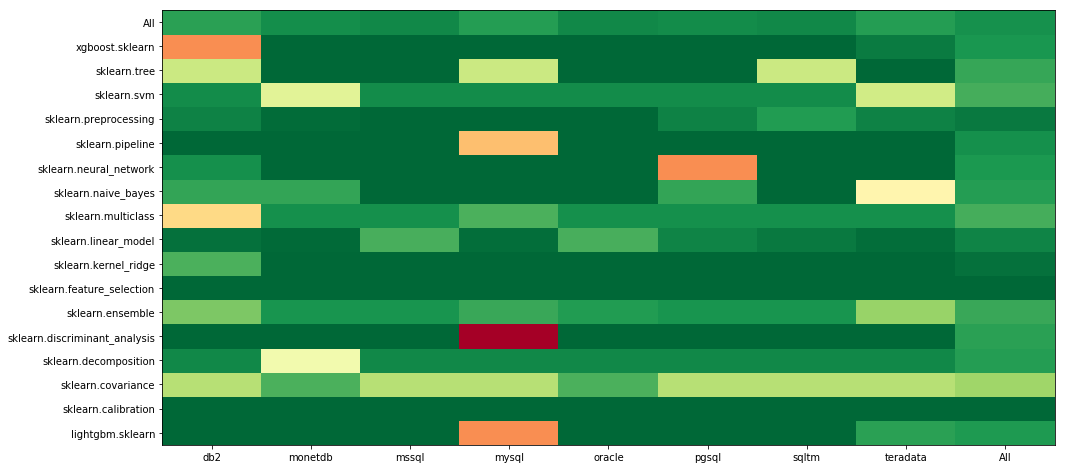

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 48
'monetdb',  SUCCESS                                                 48
'mssql',    SUCCESS                                                 48
'mysql',    SUCCESS                                                 30
            TIMEOUT                                                 18
'oracle',   SUCCESS                                                 48
'pgsql',    SUCCESS                                                 48
'sqltm',    SUCCESS                                                 48
'teradata', SUCCESS                                                 45
            'DatabaseError:(teradata.api.DatabaseError)              3

mean                                                    \
dialect              db2 monetdb mssql  mysql oracle pgsql sqltm  teradata   
Model                                                                        
LGBMClassifier       0.0     0.0   0.0  0.000    0.0   0.0   0.0  0.000000   
LGBMClassifier_pipe  0.0     0.0   0.0  1.000    0.0   0.0   0.0  0.166667   
LGBMRegressor        0.0     0.0   0.0  0.000    0.0   0.0   0.0  0.000000   
LGBMRegressor_pipe   0.0     0.0   0.0  0.000    0.0   0.0   0.0  0.000000   
All                  0.0     0.0   0.0  0.375    0.0   0.0   0.0  0.062500   

                               
dialect                   All  
Model                          
LGBMClassifier       0.000000  
LGBMClassifier_pipe  0.145833  
LGBMRegressor        0.000000  
LGBMRegressor_pipe   0.000000  
All                  0.054688

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,36
"'monetdb',",SUCCESS,36
"'mssql',",SUCCESS,36
"'mysql',",SUCCESS,36
"'oracle',",SUCCESS,36
"'pgsql',",SUCCESS,36
"'sqltm',",SUCCESS,36
"'teradata',",SUCCESS,36


mean                                         \
dialect                      db2 monetdb mssql mysql oracle pgsql sqltm   
Model                                                                     
CalibratedClassifierCV         0       0     0     0      0     0     0   
CalibratedClassifierCV_pipe    0       0     0     0      0     0     0   
All                            0       0     0     0      0     0     0   

                                          
dialect                     teradata All  
Model                                     
CalibratedClassifierCV             0   0  
CalibratedClassifierCV_pipe        0   0  
All                                0   0

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'monetdb',  SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2   monetdb     mssql     mysql    oracle   
Model                                                                     
EllipticEnvelope       0.333333  0.166667  0.333333  0.333333  0.166667   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.000000   
All                    0.166667  0.083333  0.166667  0.166667  0.083333   

                                                               
dialect                   pgsql     sqltm  teradata       All  
Model                                                          
EllipticEnvelope       0.333333  0.333333  0.333333  0.291667  
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  
All                    0.166667  0.166667  0.166667  0.145833

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'monetdb',  SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             21
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                                    \
dialect              db2   monetdb     mssql     mysql    oracle     pgsql   
Model                                                                        
FactorAnalysis  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
FastICA         0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All             0.033333  0.233333  0.033333  0.033333  0.033333  0.033333   

                                              
dialect            sqltm  teradata       All  
Model                                         
FactorAnalysis  0.000000  0.000000  0.125000  
FastICA         0.166667  0.166667  0.166667  
IncrementalPCA  0.000000  0.000000  0.000000  
PCA             0.000000  0.000000  0.000000  
TruncatedSVD    0.000000  0.000000  0.000000  
All             0.033333  0.033333  0.058333

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message               
'db2',      SUCCESS                   36
'monetdb',  SUCCESS                   36
'mssql',    SUCCESS                   36
'mysql',    SUCCESS                   18
            TIMEOUT                   18
'oracle',   SUCCESS                   36
'pgsql',    SUCCESS                   36
'sqltm',    SUCCESS                   36
'teradata', SUCCESS                   36

mean                                         \
dialect                          db2 monetdb mssql mysql oracle pgsql sqltm   
Model                                                                         
LinearDiscriminantAnalysis         0       0     0     0      0     0     0   
LinearDiscriminantAnalysis_pipe    0       0     0     1      0     0     0   
All                                0       0     0     0      0     0     0   

                                                  
dialect                         teradata     All  
Model                                             
LinearDiscriminantAnalysis             0  0.0000  
LinearDiscriminantAnalysis_pipe        0  0.1250  
All                                    0  0.0625

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 222
            TIMEOUT                                                  18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'monetdb',  SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mssql',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mysql',    SUCCESS                                                 234
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
            TIMEOUT                                                   6
'oracle',   SUCCESS                                                 238
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
            'DatabaseError:(cx+Oracle.DatabaseError)                  2
'pgsql',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'sqltm',    SUCCESS                                                 240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'teradata', SUCCESS                                                 217
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             29
            'DatabaseError:(teradata.api.DatabaseError)               6

mean                                \
dialect                               db2   monetdb     mssql     mysql   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  1.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  1.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.119048  0.047619  0.047619  0.071429   

                                                                         \
dialect                            oracle     pgsql     sqltm  teradata   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.166667   
AdaBoostClassifier_pipe          0.055556  0.000000  0.000000  0.166667   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.055556  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.388889   
ExtraTreesClassifier_pipe        0.000000  0.000000  0.000000  0.388889   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.166667   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.055556  0.047619  0.047619  0.138889   

                                           
dialect                               All  
Model                                      
Ada

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,162
"'monetdb',",SUCCESS,162
"'mssql',",SUCCESS,162
"'mysql',",SUCCESS,162
"'oracle',",SUCCESS,162
"'pgsql',",SUCCESS,162
"'sqltm',",SUCCESS,162
"'teradata',",SUCCESS,162


mean                                                  \
dialect                  db2 monetdb mssql mysql oracle pgsql sqltm teradata   
Model                                                                          
GenericUnivariateSelect    0       0     0     0      0     0     0        0   
RFE                        0       0     0     0      0     0     0        0   
RFECV                      0       0     0     0      0     0     0        0   
SelectFdr                  0       0     0     0      0     0     0        0   
SelectFpr                  0       0     0     0      0     0     0        0   
SelectFromModel            0       0     0     0      0     0     0        0   
SelectFwe                  0       0     0     0      0     0     0        0   
SelectKBest                0       0     0     0      0     0     0        0   
SelectPercentile           0       0     0     0      0     0     0        0   
All                        0       0     0     0      0     0     0        0   

                             
dialect                 All  
Model                        
GenericUnivariateSelect   0  
RFE                       0  
RFECV                     0  
SelectFdr                 0  
SelectFpr                 0  
SelectFromModel           0  
SelectFwe                 0  
SelectKBest               0  
SelectPercentile          0  
All                       0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        11
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'monetdb',  SUCCESS                                                        12
'mssql',    SUCCESS                                                        12
'mysql',    SUCCESS                                                        12
'oracle',   SUCCESS                                                        12
'pgsql',    SUCCESS                                                        12
'sqltm',    SUCCESS                                                        12
'teradata', SUCCESS                                                        12

mean                                                  \
dialect                db2 monetdb mssql mysql oracle pgsql sqltm teradata   
Model                                                                        
KernelRidge       0.000000     0.0   0.0   0.0    0.0   0.0   0.0      0.0   
KernelRidge_pipe  0.166667     0.0   0.0   0.0    0.0   0.0   0.0      0.0   
All               0.083333     0.0   0.0   0.0    0.0   0.0   0.0      0.0   

                            
dialect                All  
Model                       
KernelRidge       0.000000  
KernelRidge_pipe  0.020833  
All               0.010417

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       477
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'monetdb',  SUCCESS                                                       481
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                       443
            TIMEOUT                                                        38
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mysql',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                       443
            TIMEOUT                                                        38
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                       467
            TIMEOUT                                                        14
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                       473
            TIMEOUT                                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                       479
            TIMEOUT                                                         2
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                                db2   monetdb     mssql     mysql   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.166667  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  0.166667  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.166667  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.000000  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.000000  0.000000  0.000000   
LogisticRegressionCV_pipe         0.000000  0.000000  0.000000  0.000000   
LogisticRegression_pipe           0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.000000  0.000000   
Perceptron_pipe                   0.000000  0.000000  0.000000  0.000000   
RANSACRegressor                   1.000000  0.000000  1.000000  1.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000  1.000000  0.000000   
RidgeClassifier_pipe              0.000000  0.000000  0.000000  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  0.000000  1.000000  0.000000   
SGDRegressor                      0.000000  0.000000  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        50
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'monetdb',  SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mssql',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mysql',    SUCCESS                                                        66
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'oracle',   SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'pgsql',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'sqltm',    SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'teradata', SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3

mean                                          \
dialect                        db2   monetdb     mssql     mysql    oracle   
Model                                                                        
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.055556  0.000000  0.000000  0.000000  0.000000   
OneVsRestClassifier       0.166667  0.166667  0.166667  0.166667  0.166667   
OneVsRestClassifier_pipe  1.000000  0.000000  0.000000  0.166667  0.000000   
All                       0.305556  0.041667  0.041667  0.083333  0.041667   

                                                                  
dialect                      pgsql     sqltm  teradata       All  
Model                                                             
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  
OneVsOneClassifier_pipe   0.000000  0.000000  0.000000  0.006944  
OneVsRestClassifier       0.166667  0.166667  0.166667  0.166667  
OneVsRestClassifier_pipe  0.000000  0.000000  0.000000  0.145833  
All                       0.041667  0.041667  0.041667  0.079861

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                
'db2',      SUCCESS                                                    84
            'DBAPIError:(ibm_db_dbi.Error)                              6
'monetdb',  SUCCESS                                                    84
            ) Math exception: Numerical result out of rang              6
'mssql',    SUCCESS                                                    90
'mysql',    SUCCESS                                                    90
'oracle',   SUCCESS                                                    90
'pgsql',    SUCCESS                                                    84
            ) value out of range: underflo                              6
'sqltm',    SUCCESS                                                    90
'teradata', SUCCESS                                                    66
            'DatabaseError:(teradata.api.DatabaseError)                24

mean                                               \
dialect                db2   monetdb mssql mysql oracle     pgsql sqltm   
Model                                                                     
BernoulliNB       0.000000  0.000000   0.0   0.0    0.0  0.000000   0.0   
BernoulliNB_pipe  0.000000  0.000000   0.0   0.0    0.0  0.000000   0.0   
GaussianNB        0.333333  0.333333   0.0   0.0    0.0  0.333333   0.0   
GaussianNB_pipe   0.000000  0.000000   0.0   0.0    0.0  0.000000   0.0   
MultinomialNB     0.000000  0.000000   0.0   0.0    0.0  0.000000   0.0   
All               0.066667  0.066667   0.0   0.0    0.0  0.066667   0.0   

                                      
dialect           teradata       All  
Model                                 
BernoulliNB       0.333333  0.041667  
BernoulliNB_pipe  0.000000  0.000000  
GaussianNB        0.666667  0.208333  
GaussianNB_pipe   0.000000  0.000000  
MultinomialNB     0.333333  0.041667  
All               0.266667  0.058333

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        46
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        30
            TIMEOUT                                                        18
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                                   \
dialect                  db2 monetdb mssql mysql oracle  pgsql sqltm teradata   
Model                                                                           
MLPClassifier       0.055556     0.0   0.0   0.0    0.0  0.000   0.0      0.0   
MLPClassifier_pipe  0.000000     0.0   0.0   0.0    0.0  1.000   0.0      0.0   
MLPRegressor        0.000000     0.0   0.0   0.0    0.0  0.000   0.0      0.0   
MLPRegressor_pipe   0.166667     0.0   0.0   0.0    0.0  0.000   0.0      0.0   
All                 0.041667     0.0   0.0   0.0    0.0  0.375   0.0      0.0   

                              
dialect                  All  
Model                         
MLPClassifier       0.006944  
MLPClassifier_pipe  0.125000  
MLPRegressor        0.000000  
MLPRegressor_pipe   0.020833  
All                 0.052083

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message               
'db2',      SUCCESS                   54
'monetdb',  SUCCESS                   54
'mssql',    SUCCESS                   54
'mysql',    SUCCESS                   36
            TIMEOUT                   18
'oracle',   SUCCESS                   54
'pgsql',    SUCCESS                   54
'sqltm',    SUCCESS                   54
'teradata', SUCCESS                   54

mean                                                          
dialect        db2 monetdb mssql mysql oracle pgsql sqltm teradata       All
Model                                                                       
FeatureUnion     0       0     0     0      0     0     0        0  0.000000
Pipeline         0       0     0     0      0     0     0        0  0.000000
Pipeline_pipe    0       0     0     1      0     0     0        0  0.125000
All              0       0     0     0      0     0     0        0  0.041667

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       210
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
'monetdb',  SUCCESS                                                       215
            TIMEOUT                                                         1
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       210
            "DatabaseError:(teradata.api.DatabaseError)                     6

mean                                         \
dialect                   db2   monetdb mssql mysql oracle     pgsql   
Model                                                                  
Binarizer            0.000000  0.000000   0.0   0.0    0.0  0.000000   
Imputer              0.000000  0.000000   0.0   0.0    0.0  0.000000   
LabelBinarizer       0.000000  0.000000   0.0   0.0    0.0  0.000000   
LabelEncoder         0.000000  0.000000   0.0   0.0    0.0  0.000000   
MaxAbsScaler         0.000000  0.000000   0.0   0.0    0.0  0.000000   
MinMaxScaler         0.000000  0.000000   0.0   0.0    0.0  0.000000   
Normalizer           0.000000  0.000000   0.0   0.0    0.0  0.000000   
OneHotEncoder        0.000000  0.000000   0.0   0.0    0.0  0.000000   
PolynomialFeatures   0.333333  0.055556   0.0   0.0    0.0  0.333333   
QuantileTransformer  0.000000  0.000000   0.0   0.0    0.0  0.000000   
RobustScaler         0.000000  0.000000   0.0   0.0    0.0  0.000000   
StandardScaler       0.000000  0.000000   0.0   0.0    0.0  0.000000   
All                  0.027778  0.004630   0.0   0.0    0.0  0.027778   

                                                   
dialect                 sqltm  teradata       All  
Model                                              
Binarizer            0.000000  0.000000  0.000000  
Imputer              0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.000000  
MinMaxScaler         0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  
OneHotEncoder        0.000000  0.000000  0.000000  
PolynomialFeatures   0.333333  0.333333  0.173611  
QuantileTransformer  0.333333  0.000000  0.041667  
RobustScaler         0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  
All                  0.055556  0.027778  0.017940

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'monetdb',  SUCCESS                                                       123
            TIMEOUT                                                        31
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              2
'mssql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'mysql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'oracle',   SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'pgsql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'sqltm',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'teradata', SUCCESS                                                       126
            'DatabaseError:(teradata.api.DatabaseError)                    30

mean                                                    \
dialect                db2   monetdb     mssql     mysql    oracle     pgsql   
Model                                                                          
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC_pipe        0.333333  0.666667  0.333333  0.333333  0.333333  0.333333   
NuSVR             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.055556  0.000000  0.000000  0.000000  0.000000   
SVC_pipe          0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
SVR               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All               0.038462  0.211538  0.038462  0.038462  0.038462  0.038462   

                                                
dialect              sqltm  teradata       All  
Model                                           
LinearSVC         0.000000  0.000000  0.000000  
LinearSVC_pipe    0.000000  0.000000  0.000000  
LinearSVR         0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  
NuSVC             0.000000  0.500000  0.062500  
NuSVC_pipe        0.333333  0.500000  0.395833  
NuSVR             0.000000  0.000000  0.000000  
NuSVR_pipe        0.000000  0.000000  0.041667  
OneClassSVM       0.000000  0.000000  0.000000  
OneClassSVM_pipe  0.000000  0.000000  0.000000  
SVC               0.000000  0.333333  0.048611  
SVC_pipe          0.000000  0.333333  0.166667  
SVR               0.000000  0.000000  0.000000  
SVR_pipe          0.000000  0.000000  0.000000  
All               0.038462  0.192308  0.079327

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message               
'db2',      SUCCESS                   78
            TIMEOUT                   18
'monetdb',  SUCCESS                   96
'mssql',    SUCCESS                   96
'mysql',    SUCCESS                   78
            TIMEOUT                   18
'oracle',   SUCCESS                   96
'pgsql',    SUCCESS                   96
'sqltm',    SUCCESS                   78
            TIMEOUT                   18
'teradata', SUCCESS                   96

mean                                         \
dialect                      db2 monetdb mssql mysql oracle pgsql sqltm   
Model                                                                     
DecisionTreeClassifier         0       0     0     0      0     0     0   
DecisionTreeClassifier_pipe    1       0     0     0      0     0     1   
DecisionTreeRegressor          0       0     0     0      0     0     0   
DecisionTreeRegressor_pipe     0       0     0     0      0     0     0   
ExtraTreeClassifier            0       0     0     0      0     0     0   
ExtraTreeClassifier_pipe       0       0     0     1      0     0     0   
ExtraTreeRegressor             0       0     0     0      0     0     0   
ExtraTreeRegressor_pipe        0       0     0     0      0     0     0   
All                            0       0     0     0      0     0     0   

                                                
dialect                     teradata       All  
Model                                           
DecisionTreeClassifier             0  0.000000  
DecisionTreeClassifier_pipe        0  0.250000  
DecisionTreeRegressor              0  0.000000  
DecisionTreeRegressor_pipe         0  0.000000  
ExtraTreeClassifier                0  0.000000  
ExtraTreeClassifier_pipe           0  0.125000  
ExtraTreeRegressor                 0  0.000000  
ExtraTreeRegressor_pipe            0  0.000000  
All                                0  0.070312

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  30
            TIMEOUT                                                  18
'monetdb',  SUCCESS                                                  48
'mssql',    SUCCESS                                                  48
'mysql',    SUCCESS                                                  48
'oracle',   SUCCESS                                                  48
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48
'teradata', SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1

mean                                                   \
dialect               db2 monetdb mssql mysql oracle pgsql sqltm  teradata   
Model                                                                        
XGBClassifier       0.000     0.0   0.0   0.0    0.0   0.0   0.0  0.055556   
XGBClassifier_pipe  1.000     0.0   0.0   0.0    0.0   0.0   0.0  0.000000   
XGBRegressor        0.000     0.0   0.0   0.0    0.0   0.0   0.0  0.000000   
XGBRegressor_pipe   0.000     0.0   0.0   0.0    0.0   0.0   0.0  0.000000   
All                 0.375     0.0   0.0   0.0    0.0   0.0   0.0  0.020833   

                              
dialect                  All  
Model                         
XGBClassifier       0.006944  
XGBClassifier_pipe  0.125000  
XGBRegressor        0.000000  
XGBRegressor_pipe   0.000000  
All                 0.049479

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
